# 百度指数技术分享

## 百度指数难点:

1. 需要账号登录才能进入搜索页面
2. 页面上的所要抓取的信息是图片

根据以上2个难点, 设计解决方案:
1. 用预先注册好的账号登录, 获取该账号的cookies, 用于后续的模拟登录.
2. 使用selenium 自动化测试工具, 进行模拟浏览器的操作, 可以将得到的cookie带入浏览器请求中, 直接跳过输入账号的步骤.
3. 使用selenium 模拟输入关键词, 跳转到结果页面后, 对页面进行截图操作, 将图片保存到本地.
4. 利用python的PIL模块 + opencv, 对进行各种图像处理, 最终得到只带有数字的图片, 提高后续图像识别的准确性.
5. 利用tesseract对图片进行辨识.

关于部署:
1. 首先要把 selenium 的服务开启. P.S.:由于官方docker中默认不支持中文, 所以原有的docker基础上, 按需加了一层中文字符集的images.
2. 关于在docker中安装opencv, 由于在本地环境 与 线上环境 硬件上的不一致, 导致在本地编译完的opencv, 放到线上环境会报错, 所以需要到与线上环境一致的机器上对项目进行docker化的打包.


In [19]:
cookies = [{'domain': '.baidu.com',
  'httpOnly': False,
  'name': 'H_PS_PSSID',
  'path': '/',
  'secure': False,
  'value': '1453_26458_21118_26580_22160'},
 {'domain': 'www.baidu.com',
  'expiry': 1529544786,
  'httpOnly': False,
  'name': 'BD_UPN',
  'path': '/',
  'secure': False,
  'value': '123253'},
 {'domain': 'www.baidu.com',
  'httpOnly': False,
  'name': 'BD_HOME',
  'path': '/',
  'secure': False,
  'value': '1'},
 {'domain': '.baidu.com',
  'expiry': 3676164433.012751,
  'httpOnly': False,
  'name': 'PSTM',
  'path': '/',
  'secure': False,
  'value': '1528680785'},
 {'domain': '.baidu.com',
  'expiry': 3676164433.012714,
  'httpOnly': False,
  'name': 'BIDUPSID',
  'path': '/',
  'secure': False,
  'value': '995664793CC13229F89D16F99C1168EF'},
 {'domain': '.baidu.com',
  'expiry': 1787880784.908475,
  'httpOnly': True,
  'name': 'BDUSS',
  'path': '/',
  'secure': False,
  'value': 'J3LU9XZ3pJZlpkZFh5ZmRnaUFqVUlKVn5WQ2RIdnFkVkxnWUhRajZMcWNqYUJlSVFBQUFBJCQAAAAAAAAAAAEAAAB89zgF0rnTzsnxX7PBy68AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwAeV6cAHleUl'},
 {'domain': '.baidu.com',
  'expiry': 2556057600,
  'httpOnly': False,
  'name': 'FP_UID',
  'path': '/',
  'secure': False,
  'value': '14ff0d30f441dd62966914f9bc7c48b1'},
 {'domain': '.baidu.com',
  'expiry': 1560216778.684929,
  'httpOnly': False,
  'name': 'BAIDUID',
  'path': '/',
  'secure': False,
  'value': '669274D907DB456C7E9B5299224B7906:FG=1'}] # 这里需要自己填写

In [22]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.action_chains import ActionChains
import time
import re


In [46]:
# browser = webdriver.Remote(
#     command_executor="http://localhost:4444/wd/hub",
#     desired_capabilities=DesiredCapabilities.CHROME
# )
browser = webdriver.Chrome("/Users/fuxin/Documents/jupyter_dir/chromedriver")
url = "http://index.baidu.com/#/"
browser.get(url)
browser.viewportSize = {"width":1280, "height":1024}
for i in cookies:
    browser.add_cookie(i)
browser.set_window_size(1280, 1024)
browser.refresh()

In [47]:
browser.find_element_by_class_name("search-input").clear()
browser.find_element_by_class_name("search-input").send_keys("魅族手机")
browser.find_element_by_class_name("search-input-cancle").click()
time.sleep(1)

坑点1: 
1. 右下角的几个小图标会影响到后面的操作, 所以提前删去
2. 在图中的会有很多坐标线, 在截图时, 如果刚好与数字重叠, 会影响辨识, 于是提前去除

In [29]:
browser.execute_script("$('#yeyingKefuWidget').remove();$('#rTools').remove();") # 删除 右下角小图标
browser.execute_script('$("path").remove();')  # 去掉svg里的背景
browser.execute_script('$("text").remove();')
time.sleep(1)

WebDriverException: Message: unknown error: $ is not defined
  (Session info: chrome=80.0.3987.149)
  (Driver info: chromedriver=2.39.562713 (dd642283e958a93ebf6891600db055f1f1b4f3b2),platform=Mac OS X 10.15.3 x86_64)


# 抓取最近7天的数据

In [54]:
# browser.find_element_by_xpath("//a[@class='chartselect'][1]").click() # 点击按钮 "7天"

xoyelement = browser.find_elements_by_css_selector(".content-wrapper")[2]  #  获取 图表 html
# 获取图表的长宽
xoyelement_size = xoyelement.size  
width, height = int(xoyelement_size["width"]), int(xoyelement_size["height"])

# 计算出鼠标移动的步长
times = 10
step = width / times
print(width, height)


x = 1
y = 20
for i in range(times+1):
    # 将鼠标移动到 图表的 (0, 20)位置 (左上角为(0,0))
    if x > width or i == times:
        x = width - 2
    ActionChains(browser).move_to_element_with_offset(xoyelement, x, y).perform() 
    time.sleep(2)
    
    # 判断小框是否已出现
#     viewbox = browser.find_element_by_id("viewbox")
#     if viewbox.is_displayed(): # 判断小框是否出现
    if True:
#         # 获取日期
#         element = browser.find_element_by_xpath("//div[@class='view-table-wrap']")
#         date_string = element.text
#         pattern = r"(\d+)"
#         date = re.findall(pattern, date_string)
#         date = "-".join(date)
#         print(date)
        
        # 获取热度
#         browser.execute_script('$(".view-dot").remove();$(".view-label").remove();')       
        path = "./screenshot2/{0}.png".format(i)
        browser.save_screenshot(path) # 这里就是截屏操作
        
    break    
    x = x + step

1175 467


# opencv部分

In [34]:
import cv2
import numpy as np
from PIL import Image, ImageOps


In [35]:
def dilate_img(img, kernel=np.ones((2,2), np.int8), iterations=1):
    """
      膨胀
      img: 灰度图
      kernel: 核大小
      iterations: 迭代次数
    """
    dilate = cv2.dilate(np.array(img), kernel, iterations=iterations)
    return dilate

def erode_img(img, kernel=np.ones((2,2), np.int8), iterations=1):
    """
      腐蚀
      img: 灰度图
      kernel: 核大小
      iterations: 迭代次数
    """
    erode = cv2.erode(np.array(img), kernel, iterations=iterations)
    return erode

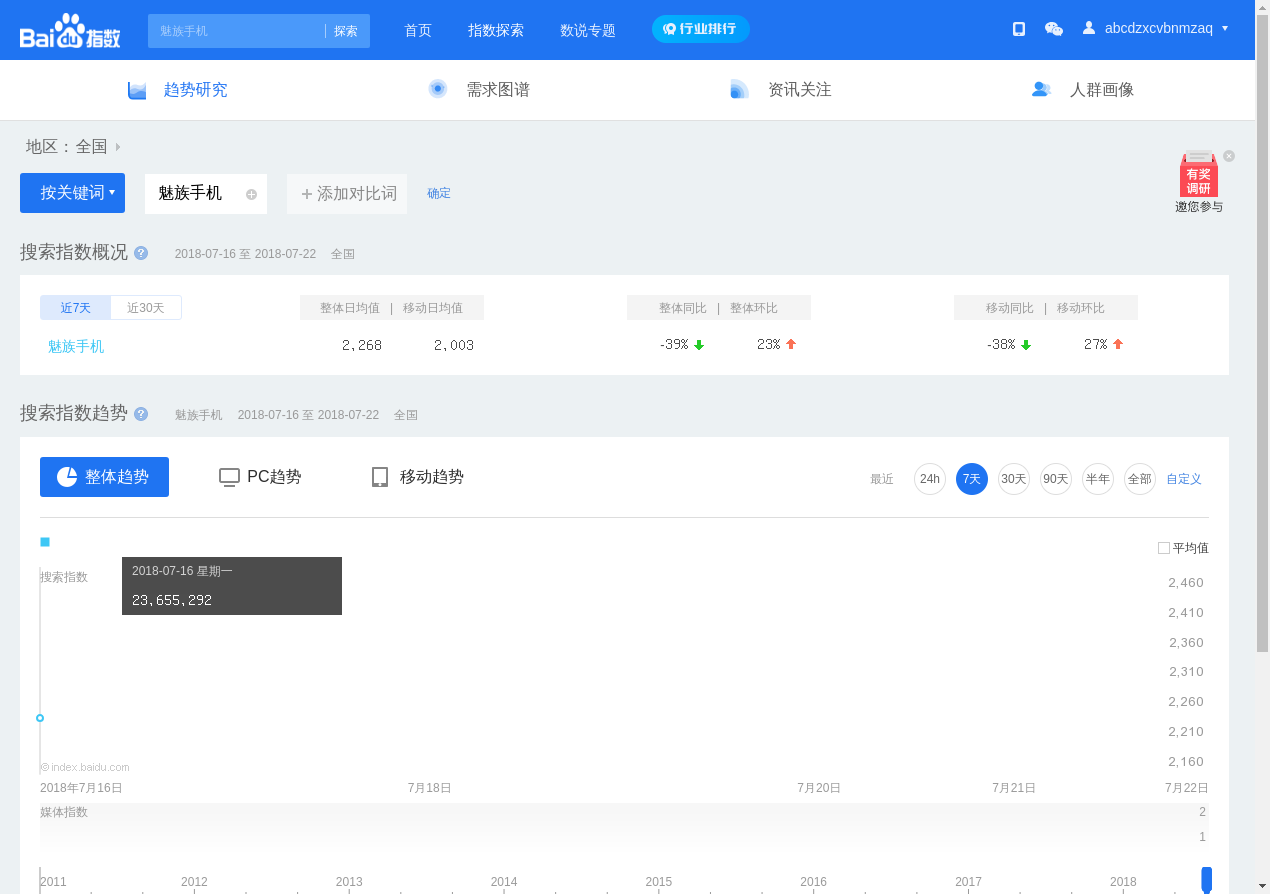

In [36]:
img = Image.open("./screenshot/{0}.png".format(0))
img

# 步骤:
1. 滤波
2. 去噪
3. 抠图
4. 截取

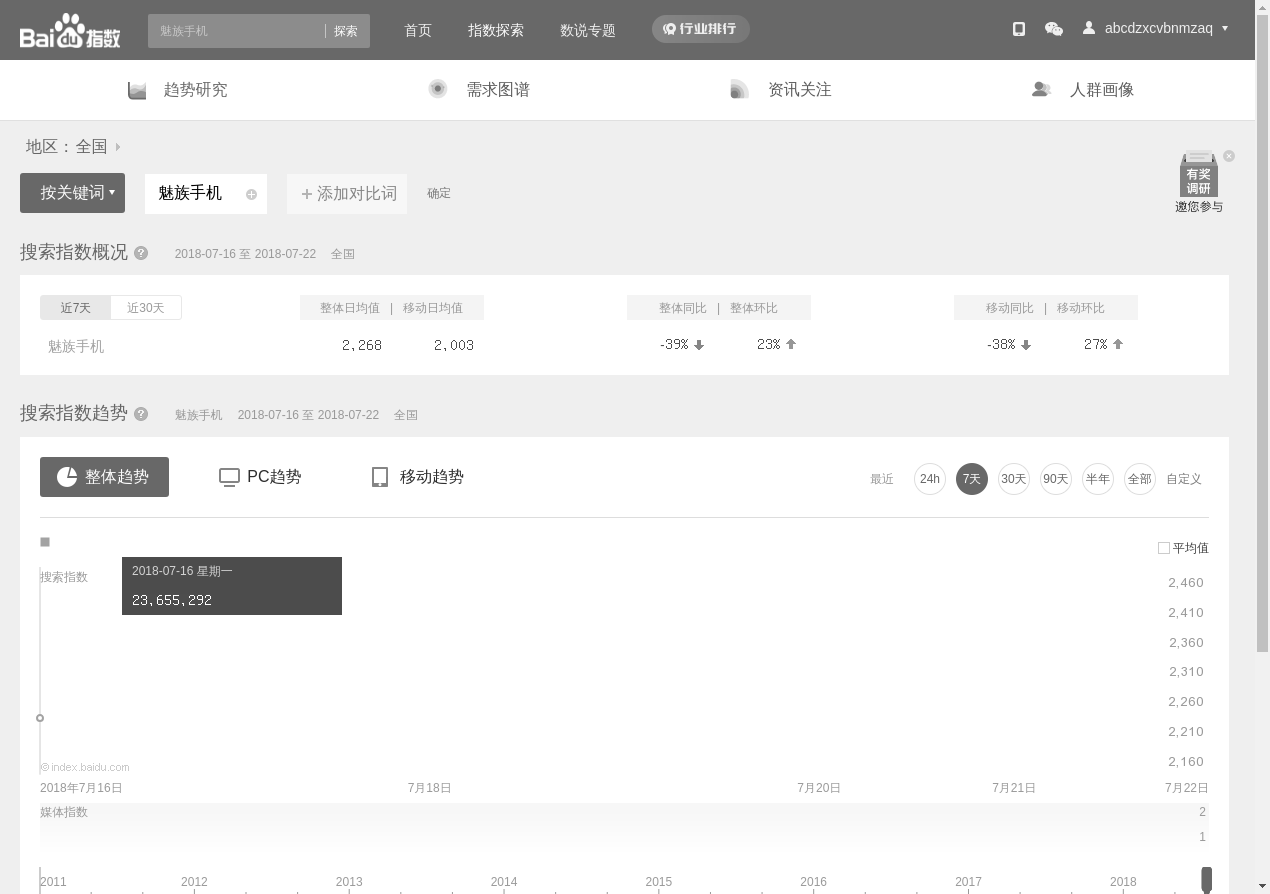

In [38]:
# 滤波
# 变成灰度图
gray_img = img.convert("L")
gray_img

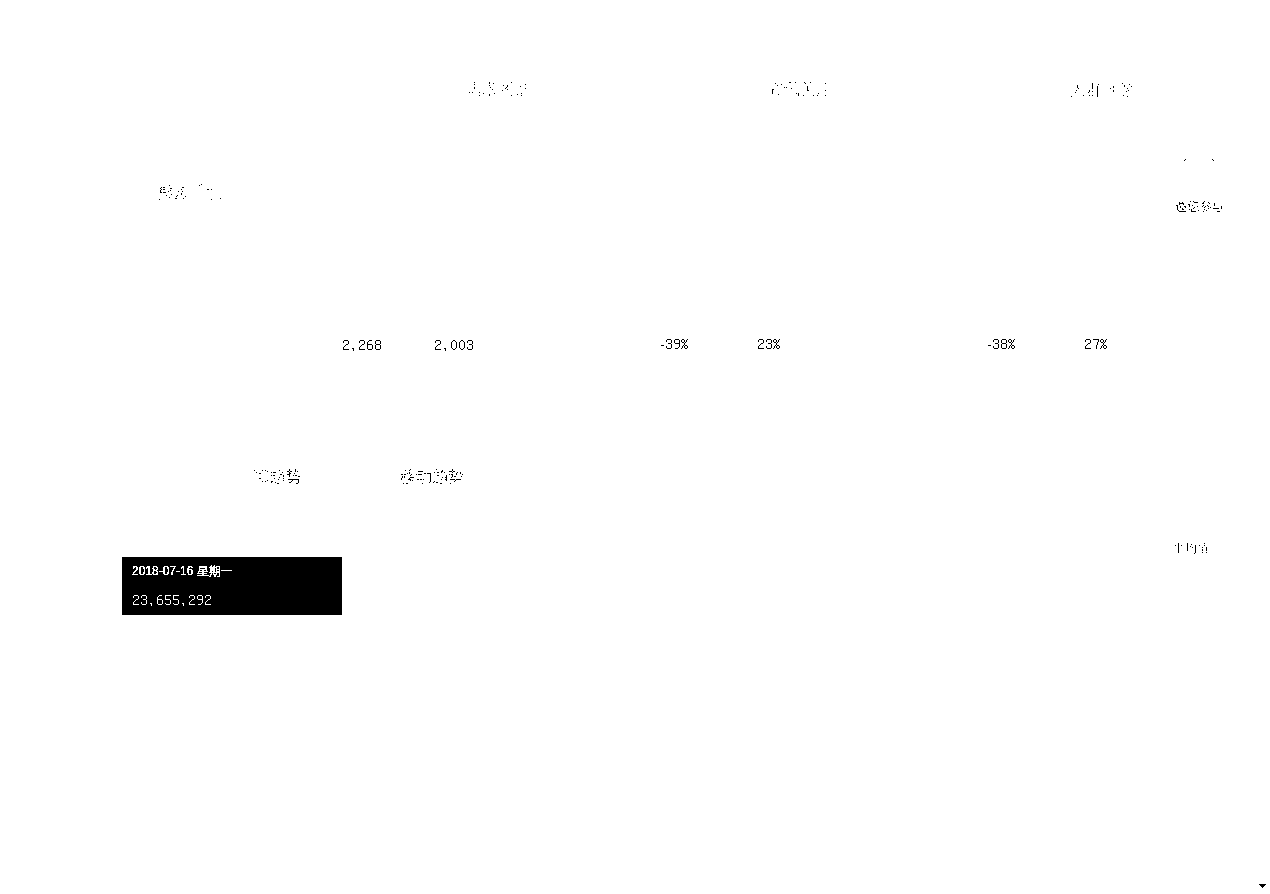

In [39]:
# 过滤掉不要的点
array = np.array(gray_img)
array[array < 65] = 255
array[array > 100] = 255
array[array != 255] = 0
newimg = Image.fromarray(array)
newimg

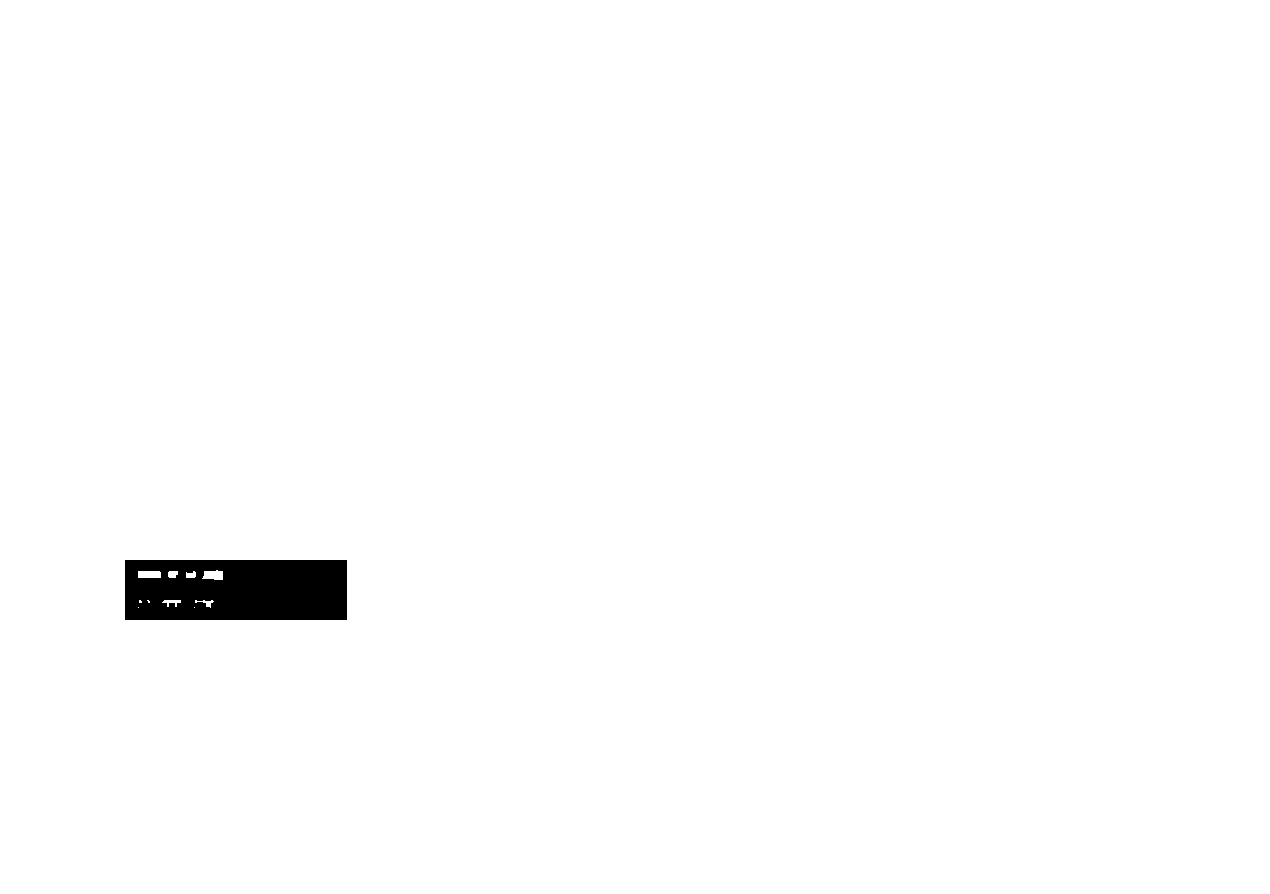

In [40]:
# 去噪
array = dilate_img(newimg, iterations=3)
array = erode_img(Image.fromarray(array), iterations=5)
display(Image.fromarray(array))

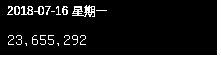

In [41]:
# 抠图
array[array == 0] = 1
array[array != 1] = 0
x_sum_list = array.sum(axis=0).nonzero()[0]
x_min = x_sum_list.min()
x_max = x_sum_list.max()
y_sum_list = array.sum(axis=1).nonzero()[0]
y_min = y_sum_list.min()
y_max = y_sum_list.max()
trangle = (x_min, y_min, x_max, y_max)
crop_img = newimg.crop(trangle)
crop_img

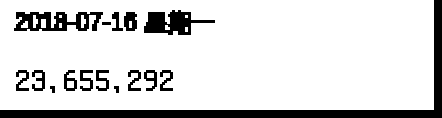

In [42]:
# 翻转
size = crop_img.size
crop_img = crop_img.resize((size[0] * 2, size[1] * 2), resample=cv2.INTER_CUBIC)
crop_img = cv2.medianBlur(np.array(crop_img), 1)
crop_img = erode_img(crop_img)
crop_img[crop_img != 0] = 255
crop_img = Image.fromarray(crop_img)
crop_img = ImageOps.invert(crop_img)
crop_img

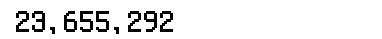

In [43]:
# 截取
size = crop_img.size
rect = (0, size[1]/2, size[0] - 60, size[1]-20)
crop_img_num = crop_img.crop(rect)
crop_img_num

坑点2:
在这个时候, 其实可以直接把crop_img_num放到 tesseract 中进行识别, 但是 tesseract4.0中加入了LSTM的一些机制, 导致它在辨识的过程当中,会考虑前后字符的关系, 于是我决定自己做字符拆分.

In [44]:
# 字符拆分

# 过滤
threshold = 100
img_arr = np.array(crop_img_num)
size = img_arr.shape
img_arr[img_arr > threshold] = 255
img_arr[img_arr <= threshold] = 0
img_arr[(img_arr != 0) & (img_arr != 255)]


# x轴映射
col_sum = img_arr.sum(axis=0)
col_sum = col_sum * (-1) + 255 * size[0]
col_nonzero_list = col_sum.nonzero()[0]
    # print(col_nonzero_list)

# 根据x轴的映射进行split操作
s = 0
col_split = []
for i in range(1, len(col_nonzero_list)):
    if i == (len(col_nonzero_list) - 1):
        one_split = (col_nonzero_list[s], col_nonzero_list[i])
        col_split.append(one_split)
        break
    
    if (col_nonzero_list[i] - col_nonzero_list[i - 1]) > 1:
        one_split = (col_nonzero_list[s], col_nonzero_list[i - 1])
        col_split.append(one_split)
        s = i

# y轴映射, 主要是去掉 逗号(",")
bias = 3
result = []
for i in col_split:
    split_img_arr = img_arr[:, i[0] - bias:i[1] + bias]
    size = split_img_arr.shape
    split_img = Image.fromarray(split_img_arr)
    row_sum = split_img_arr.sum(axis=1)
    row_sum = row_sum * (-1) + 255 * size[1]
    row_nonzero_list = row_sum.nonzero()[0]
    if len(row_nonzero_list) <= 10:
        continue
    result.append(split_img)
for i in result:
    display(i)

坑点3
1. pytesseract.image_to_string(img) 默认的配置辨识度非常低, 需要加一些参数进去. 我这里的做法是对同一个图片用4中不同的参数, 得到4个辨识结果, 然后取4个辨识结果里出现最多的情况作为最后的结果.
2. "8"这个图片是永远认不出来的, 把辨识结果为空的地方都默认为8.


In [45]:
# tessearct
import pytesseract
from collections import Counter
number = []
for i in result:
    a = []
    a1 = pytesseract.image_to_string(i, lang='eng',
                                     config="--psm 7 -c tessedit_char_whitelist=0123456789")
    if a1.isnumeric():
        a.append(a1)
    
    a2 = pytesseract.image_to_string(i, lang='eng',
                                     config="--psm 8 -c tessedit_char_whitelist=0123456789")
    if a2.isnumeric():
        a.append(a2)

    a3 = pytesseract.image_to_string(i, lang='eng',
                                     config="--psm 9 -c tessedit_char_whitelist=0123456789")
    if a3.isnumeric():
        a.append(a3)

    a4 = pytesseract.image_to_string(i, lang='eng',
                                     config="--psm 10 -c tessedit_char_whitelist=0123456789")
    if a4.isnumeric():
        a.append(a4)

    c = Counter(a)
    a = c.most_common(1)
    print("a:", a)
    
    if a and a[0][0].isnumeric():
        number.append(a[0][0])
    if not a:
        number.append("8")
    
print("".join(number))


a: [('2', 4)]
a: [('3', 4)]
a: [('6', 4)]
a: [('5', 4)]
a: [('5', 4)]
a: [('2', 4)]
a: [('9', 4)]
a: [('2', 4)]
23655292
